In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import vr2p
import pandas as pd
from vr2p import styles
import gcsfs
from tqdm.notebook import tqdm
import pickle
from matplotlib import pyplot as plt

# Main parameters

In [2]:
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
bin_size =10

# Load clustered mask information
Only include used ones since those are the only ones we have activity data for.

In [ ]:
def collect_masks(animal):
    fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
    with fs.open(f'/.../registration/match-Tyche-{animal}.pkl', 'rb') as handle:
        matched_masks, matched_im, template_masks, template_im = pickle.load(handle)
    return {'animal':animal,'num_sessions': len(matched_im), 'matched_masks':matched_masks, 
            'matched_im':matched_im,'template_masks':template_masks,
            'template_im':template_im}
matched_info = [ collect_masks(animal) for animal in tqdm(animals)]

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
plot_info = []
for info in tqdm(matched_info):
    animal = info['animal']
    # find mask info for this animal
    matched_masks = info['matched_masks']
    template_masks = info['template_masks']
    # get activity data
    data = vr2p.ExperimentData(f'/.../linear-2ac/Set A/Tyche-{animal}-SetA.zarr')
    # go through all template masks
    presence_perc = []
    for template_mask in template_masks:
        # get the template mask id
        template_mask_id = template_mask['id']
        # get presence measure for this mask
        presence_perc.append((template_mask['num_sessions']/info['num_sessions'])*100)
    presence_perc = np.array(presence_perc)
    # get activity score for all cells (more efficient all at once then for each mask individually)
    act_scores = []
    for session in range(info['num_sessions']):
        F = data.signals.multi_session.spks[session] 
        act_scores.append(np.mean(F,axis=1))
    act_scores = np.mean(np.vstack(act_scores),axis=0)
    # store.
    for i in range(len(act_scores)):
        plot_info.append({'animal':animal,'act_score':act_scores[i],'presence_perc':presence_perc[i]})
# turn into dataframe
plot_info = pd.DataFrame(plot_info)

  0%|          | 0/11 [00:00<?, ?it/s]

# Generate histogram

In [15]:
# add bin based on presence_perc left indlusion
plot_info['presence_bin'] = pd.cut(plot_info['presence_perc'],bins=np.arange(50,100+bin_size,bin_size),labels=np.arange(50+(bin_size/2),100,bin_size),include_lowest=True).astype(int)
# group by animal and aggregate mean, std, and sem
hist_info_all = plot_info.groupby(['animal','presence_bin']).agg({'act_score':['mean']}).reset_index()
# rename mean column to act score
hist_info_all.columns = ['animal','presence_bin','act_score']
# now groupby presence_bin and aggregate mean, std, and sem
hist_info = hist_info_all.groupby(['presence_bin']).agg({'act_score':['mean','std','sem']}).reset_index()
display(hist_info_all)
display(hist_info)
result_m = hist_info['act_score']['mean'].values
result_std = hist_info['act_score']['std'].values

,animal,presence_bin,act_score
0,A4,55,0.350260
1,A4,65,0.403434
2,A4,75,0.435760
3,A4,85,0.482787
4,A4,95,0.542952
5,A5,55,0.323041
6,A5,65,0.345514
7,A5,85,0.380021
8,A5,95,0.449984
9,A7,55,0.331562


presence_bin act_score                    
                    mean       std       sem
0           55  0.320118  0.037262  0.011235
1           65  0.337238  0.035771  0.012647
2           75  0.372466  0.042124  0.014893
3           85  0.384583  0.053363  0.016875
4           95  0.436962  0.051420  0.015504

# plot histogram

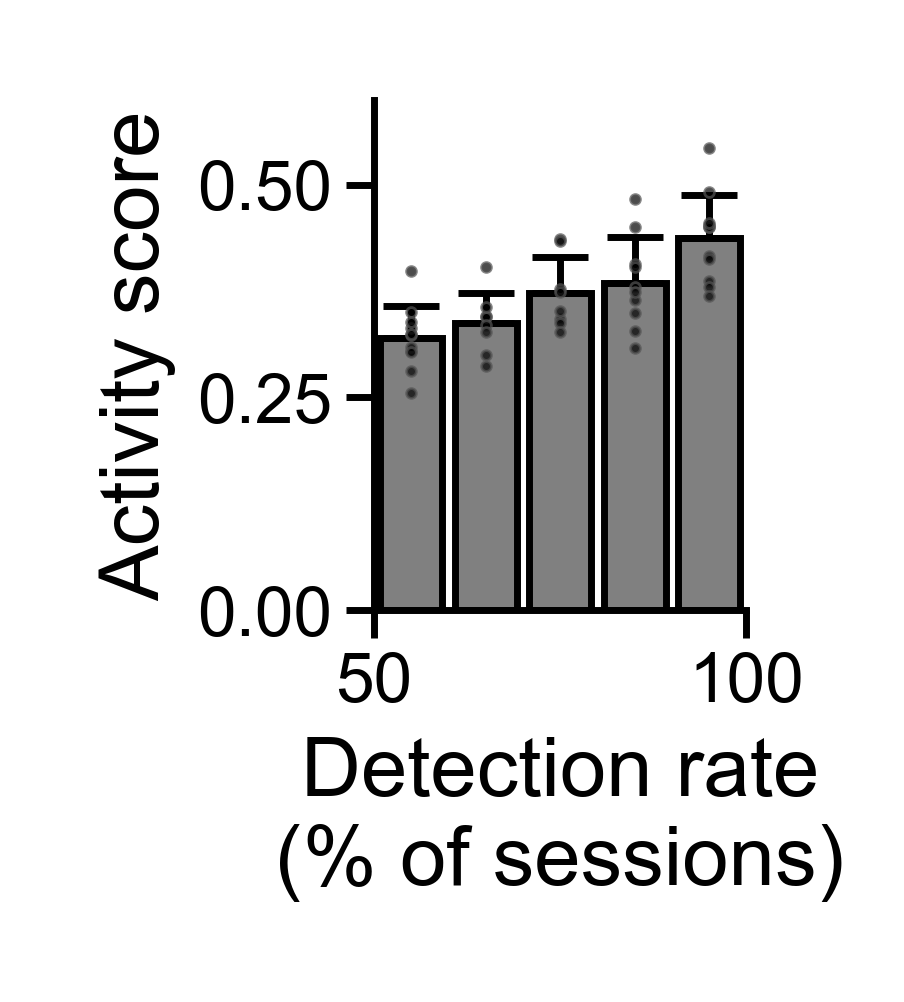

In [14]:
plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(20/25.4 ,22.5/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['plot'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,],
    # set the width ratios between the columns
    width_ratios=[1],
)
ax = axs['plot']
x_pos = np.arange(50+(bin_size/2), 100,bin_size)
ax.bar(x_pos, result_m,width=bin_size/1.2, color='gray',edgecolor='black',linewidth=0.5)
y_err = np.array([ [0,err] for err in result_std]).T
ax.errorbar(x_pos,result_m,
           yerr = y_err,fmt='none',solid_capstyle='projecting',
            capsize=2,color='black',capthick=0.5,elinewidth=0.5)
# set x ticks
ax.set_xlim(50,100)
ax.set_xlabel('Detection rate\n(% of sessions)')
ax.set_ylabel('Activity score')
# add spots for each animal
for animal in animals:
    values = hist_info_all[hist_info_all['animal']==animal]
    ax.scatter(values['presence_bin'],values['act_score'], s=0.5, c='black', alpha=0.7, edgecolor='#555555', linewidth=0.2, zorder=1000)
 